# data preproccessing


## import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
pd.set_option('max.rows', None)
pd.set_option('max.columns', None)


from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### configurations
* data_input_path -> string, filepath to data to be read in

* grouping -> boolean, if set to True them many sites are grouped
* reduced_grouping -> boolean, if set to True then less sites grouped, only bedrock sites 'WB' and 'BX are grouped into one class and superficial sites 'SV' and 'SE' are grouped into one class.
* raw -> boolean, if set to True then no grouping done
* drop_semi_bedrock ->  True|False, if set to True then some bedrock sites deemed to be semi-bedrock sites are not used for classification
* bedrock_only -> only train model using bedrock samples



In [2]:
data_input_path = '../data/raw_data.csv'


grouping = False
reduced_grouping = True
raw = False
drop_semi_bedrock = False
bedrock_only = True

### Import data

In [3]:
my_data = pd.read_csv(data_input_path)

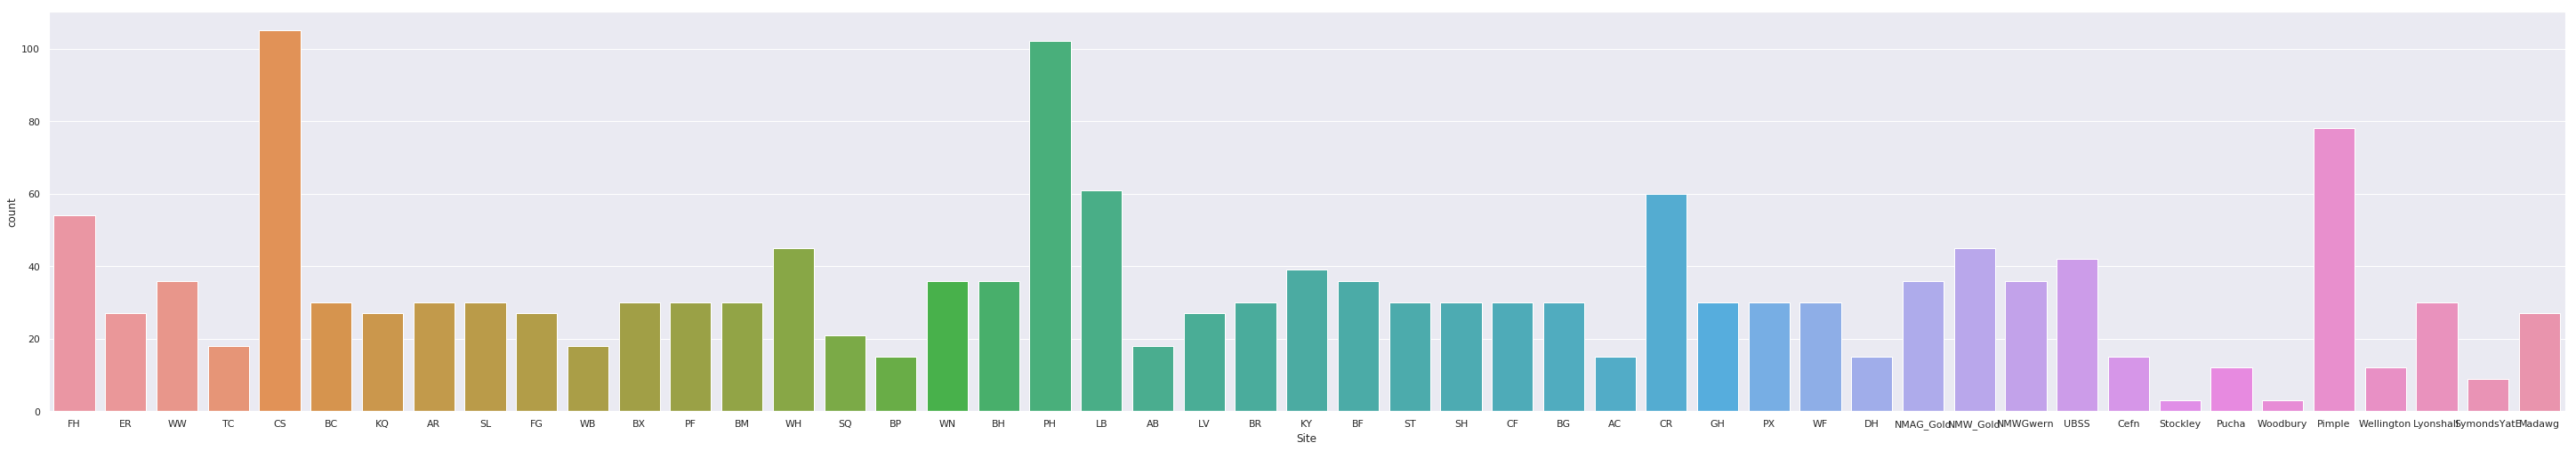

In [4]:
sns.set(rc={'figure.figsize':(50.7,8.27)})
sns.countplot(my_data['Site'])

### features

In [5]:
my_data.columns.values[9:-1]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232'], dtype=object)

### remove bedrock site 'BP' because class-specific F1 score was very bad due to limited sample number 

In [6]:
my_data = my_data[my_data['Site']!='BP']

In [7]:
site_frequencies_df = pd.DataFrame(my_data.Site.value_counts()).reset_index(drop = False).rename(columns = {'Site':'Number of Observations', 'index':'Site'})
%store site_frequencies_df

Stored 'site_frequencies_df' (DataFrame)


### raw sample names including sample sites and artefacts

In [8]:
my_data['Site'].unique()

array(['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB',
       'BX', 'PF', 'BM', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', 'AB', 'LV',
       'BR', 'KY', 'BF', 'ST', 'SH', 'CF', 'BG', 'AC', 'CR', 'GH', 'PX',
       'WF', 'DH', 'NMAG_Gold', 'NMW_Gold', 'NMWGwern', 'UBSS', 'Cefn',
       'Stockley', 'Pucha', 'Woodbury', 'Pimple', 'Wellington',
       'Lyonshall', 'SymondsYatE', 'Madawg', nan], dtype=object)

### define functions for making target classes for classification

In [9]:

def make_classes_grouped(row):
    if row['Geology'] == 'Bedrock':
        if row['Site'] == 'WB' or row['Site'] == 'BX':
            return('WB_BX')
        elif row['Site'] == 'BC' or row['Site'] == 'CS':
            return('BC_CS')
        elif row['Site'] == 'SQ' or row['Site'] == 'BP':
            return('SQ_BP')
        else:
            return(row['Site'])
    elif row['Geology'] == 'Superficial':
        if row['Region'] == 'SV' or row['Region'] == 'SE':
            return('SV_SE')
        else:
            return(row['Region'])
        
def make_classes_grouped_reduced(row):
    if row['Geology'] == 'Bedrock':
        if row['Site'] == 'WB' or row['Site'] == 'BX':
            return('WB_BX')
        else:
            return(row['Site'])
    elif row['Geology'] == 'Superficial':
        if row['Region'] == 'SV' or row['Region'] == 'SE':
            return('SV_SE')
        else:
            return(row['Region'])

def make_classes_raw(row):
    if row['Geology'] == 'Bedrock':
        return(row['Site'])
    elif row['Geology'] == 'Superficial':
        return(row['Region'])


  

### targets for classification are made

In [10]:
my_data['class'] = 'init'   

if grouping:
    my_data['class'] = my_data.apply(make_classes_grouped, axis = 1)
elif reduced_grouping:
    my_data['class'] = my_data.apply(make_classes_grouped_reduced, axis = 1)
elif raw:
    my_data['class'] = my_data.apply(make_classes_raw, axis = 1)



In [11]:
my_data['class'].isna().any()

True

In [12]:
if drop_semi_bedrock:
    my_data = my_data[(my_data['class'] != 'BM') & (my_data['class'] != 'BC') & (my_data['class'] != 'BP') ]

### remove '<' signs and commas from feature values

In [13]:
for column_name in my_data.columns.values[9:-1]:
    def fill_less_than(row):
        if 'DL' in  str(row[column_name]):
            return(np.nan)
        if '<' in str(row[column_name]):
            return(float(row[column_name].replace('<', '').replace(',', '')))
        else:
            return(float(row[column_name]))
    my_data[column_name] = my_data.swifter.apply(fill_less_than, axis = 1)

### visualise na values

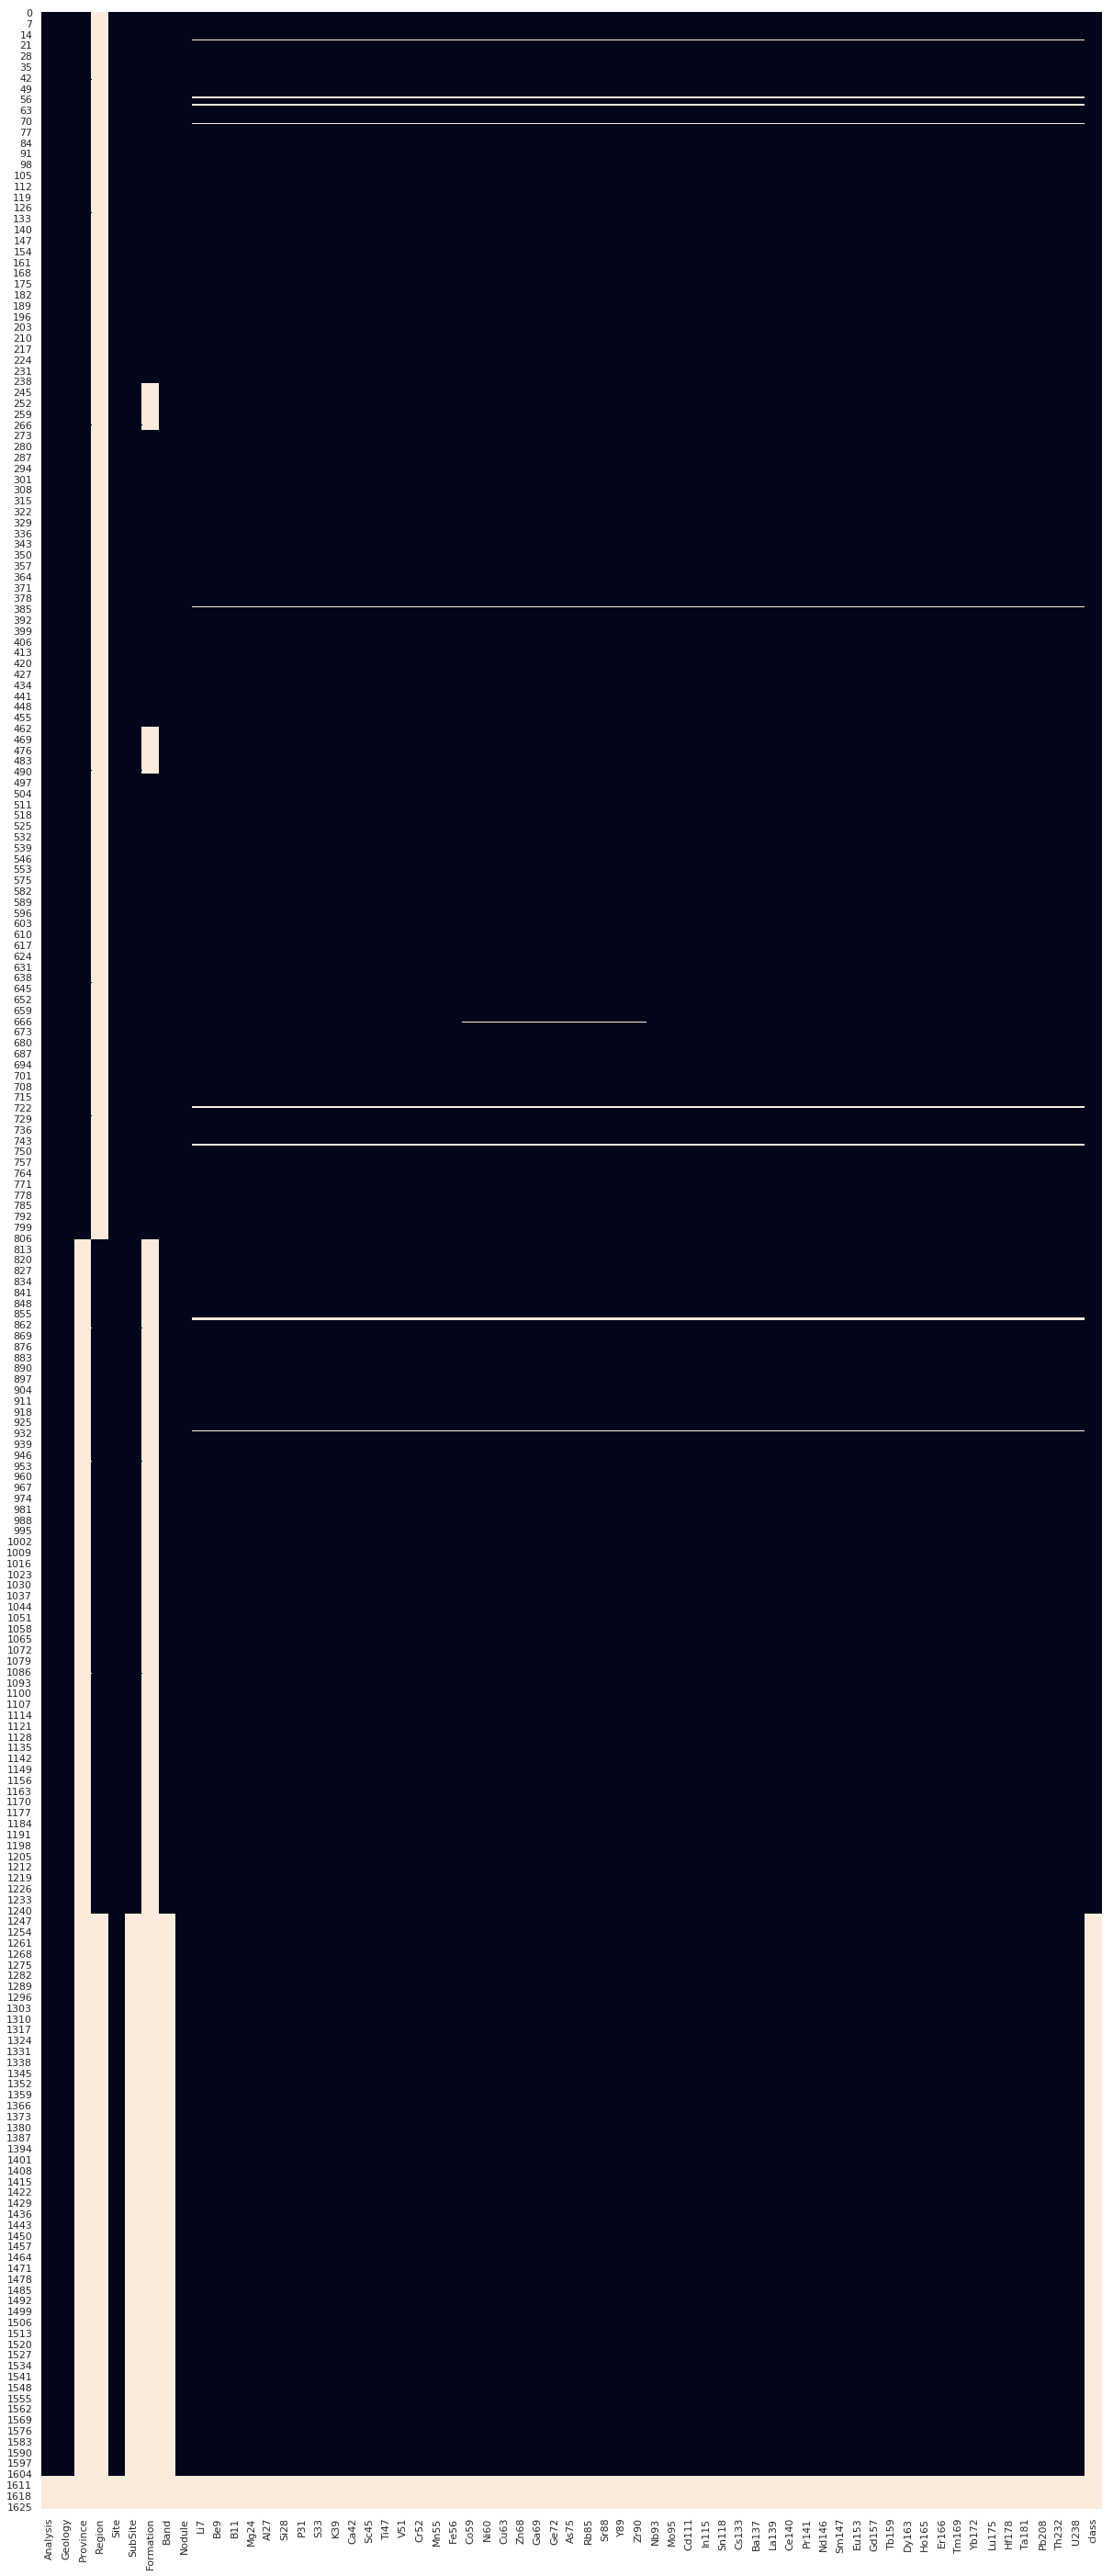

In [14]:
sns.set(rc={'figure.figsize':(20.7,50)})
sns.heatmap(my_data.isna(), cbar=False)

### remove rows where there are all element abundances are na values 

In [15]:
my_data = my_data.dropna(subset=my_data.columns.values[9:-1], how = 'all' , axis = 0)

### split data into 'train_data' and 'test_data', the former consists of samples from known geological sites and the latter from flint artefacts fow which the original geological source site is unknown and to be predicted.

In [16]:
my_data_split_geological = my_data[my_data['Geology']!= 'Artefacts']
my_data_split_artefacts = my_data[my_data['Geology']== 'Artefacts']

### Impute na values with feature mean

In [17]:
for column_name in my_data_split_geological.columns.values[9:-1]:
    my_data_split_geological[column_name] = my_data_split_geological[column_name].fillna(my_data_split_geological[column_name].mean()) 

for column_name in my_data_split_artefacts.columns.values[9:-1]:
    my_data_split_artefacts[column_name] = my_data_split_artefacts[column_name].fillna(my_data_split_artefacts[column_name].mean())     

/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Outliers defined as any values that exceed 2 standard deviations from the mean, such values are changed to the mean for that variable

In [18]:
#impute missing vaues for geological observations
std_dict_geo = {}
mean_dict_geo = {}
median_dict_geo = {}

for col in my_data_split_geological.columns.values[9:-1]:
    std_dict_geo[col] = my_data_split_geological[col].std()
    
for col in my_data_split_geological.columns.values[9:-1]:
    mean_dict_geo[col] = my_data_split_geological[col].mean()
    
for col in my_data_split_geological.columns.values[9:-1]:
    median_dict_geo[col] = my_data_split_geological[col].median()

#impute missing values for artefact observations
std_dict_art = {}
mean_dict_art = {}
median_dict_art = {}

for col in my_data_split_artefacts.columns.values[9:-1]:
    std_dict_art[col] = my_data_split_artefacts[col].std()
    
for col in my_data_split_artefacts.columns.values[9:-1]:
    mean_dict_art[col] = my_data_split_artefacts[col].mean()
    
for col in my_data_split_artefacts.columns.values[9:-1]:
    median_dict_art[col] = my_data_split_artefacts[col].median()
    
    

In [19]:
#impute outliers for geological observations
for col_name in my_data_split_geological.columns.values[9:-1]:
    def impute_outliers_geo(row):
        if np.abs(row[col_name] - mean_dict_geo[col_name]) > 2*(std_dict_geo[col_name]):
            return(mean_dict_geo[col_name])
        else:
            return(row[col_name])
    my_data_split_geological[col_name]= my_data_split_geological.swifter.apply(impute_outliers_geo, axis = 1)
    
#impute outliers for artefact samples
for col_name in my_data_split_artefacts.columns.values[9:-1]:
    def impute_outliers_art(row):
        if np.abs(row[col_name] - mean_dict_art[col_name]) > 2*(std_dict_art[col_name]):
            return(mean_dict_art[col_name])
        else:
            return(row[col_name])
    my_data_split_artefacts[col_name]= my_data_split_artefacts.swifter.apply(impute_outliers_art, axis = 1)
    



/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
print(my_data_split_geological['Geology'].unique())
print(my_data_split_artefacts['Geology'].unique())

['Bedrock' 'Superficial']
['Artefacts']


In [34]:
train_data = my_data_split_geological.copy(deep = True)
test_data = my_data_split_artefacts.copy(deep = True)


### label encode the class to be predicted

In [23]:
if bedrock_only:
    train_data_formodel = train_data[train_data['Geology'] == 'Bedrock'].copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
else:
    train_data_formodel = train_data.copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])


### datasets are stored

In [24]:
%store train_data_formodel
%store train_data
%store test_data
%store my_data
%store uniques

Stored 'train_data_formodel' (DataFrame)
Stored 'train_data' (DataFrame)
Stored 'test_data' (DataFrame)
Stored 'my_data' (DataFrame)
Stored 'uniques' (Index)


## data preproccessing for dimensionality reduction and visualisation

### 'training_data' is split into two datasets, one consisting of samples from superficial sites and one containing samples from bedrock sites.

In [25]:
train_data_bedrock = train_data[train_data['Geology'] == 'Bedrock']
train_data_superficial = train_data[train_data['Geology'] == 'Superficial']

### four datasets are created, one containing all train data (bedrock and superficial types), one containing just bedrock types, one containing just superficial types and one containing the artefacts

In [26]:
element_data_train = train_data[train_data.columns.values[9:-1]]
element_data_train_bedrock = train_data_bedrock[train_data.columns.values[9:-1]]
element_data_train_superficial = train_data_superficial[train_data.columns.values[9:-1]]
element_data_test = test_data[test_data.columns.values[9:-1]]

### features are standardised

In [27]:
my_scaler_train = StandardScaler()
my_scaler_train_bedrock = StandardScaler()
my_scaler_train_superficial = StandardScaler()
my_scaler_test = StandardScaler()

In [28]:
element_data_train_scaled = my_scaler_train.fit_transform(element_data_train)
element_data_train_bedrock_scaled = my_scaler_train_bedrock.fit_transform(element_data_train_bedrock)
element_data_train_superficial_scaled = my_scaler_train_superficial.fit_transform(element_data_train_superficial)
element_data_test_scaled = my_scaler_test.fit_transform(element_data_test)

### T-Distributed Stochastic Neighbour Embedding is done on the four datasets

In [29]:
my_tsne_train = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_train_scaled)
my_tsne_bedrock_train = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_train_bedrock_scaled)
my_tsne_superficial_train = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_train_superficial_scaled)
my_tsne_test = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_test_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1218 samples in 0.003s...
[t-SNE] Computed neighbors for 1218 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1218
[t-SNE] Computed conditional probabilities for sample 1218 / 1218
[t-SNE] Mean sigma: 2.015775
[t-SNE] Computed conditional probabilities in 0.042s
[t-SNE] Iteration 50: error = 71.9972687, gradient norm = 0.2381099 (50 iterations in 0.568s)
[t-SNE] Iteration 100: error = 71.8897629, gradient norm = 0.2384988 (50 iterations in 0.540s)
[t-SNE] Iteration 150: error = 71.7230453, gradient norm = 0.2331978 (50 iterations in 0.596s)
[t-SNE] Iteration 200: error = 71.8878250, gradient norm = 0.2190133 (50 iterations in 0.577s)
[t-SNE] Iteration 250: error = 72.0080490, gradient norm = 0.2211524 (50 iterations in 0.579s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.008049
[t-SNE] Iteration 300: error = 1.4216363, gradient norm = 0.0012376 (50 iterations in 0.356s)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-c7fbb3b69eb5>", line 1, in <module>
    my_tsne_train = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_train_scaled)
  File "/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py", line 894, in fit_transform
    embedding = self._fit(X)
  File "/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py", line 806, in _fit
    skip_num_points=skip_num_points)
  File "/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py", line 863, in _tsne
    **opt_args)
  File "/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py", line 357, in _gradient_descent
    error, grad = objective(p, *args, **kwargs)
  File "/Users/ro

KeyboardInterrupt: 

### the t-SNE dimensions for the four datasets are put into dataframes

In [ ]:
tsne_df_train = pd.DataFrame(data = my_tsne_train, columns = ['tsne1', 'tsne2'])
tsne_df_bedrock_train = pd.DataFrame(data = my_tsne_bedrock_train, columns = ['tsne1', 'tsne2'])
tsne_df_superficial_train = pd.DataFrame(data = my_tsne_superficial_train, columns = ['tsne1', 'tsne2'])
tsne_df_test = pd.DataFrame(data = my_tsne_test, columns = ['tsne1', 'tsne2'])

### datasets are stored for the purpose of two-dimensional visualisations

In [ ]:
%store tsne_df_train

%store tsne_df_bedrock_train
%store tsne_df_superficial_train


%store tsne_df_test